## `bbhx` Tutorial

`bbhx` is a software package that produces black hole binary waveforms. It focuses on LISA and provides the proper LISA response function for MBHBs ([arXiv:1806.10734](https://arxiv.org/abs/1806.10734), [arXiv:2003.00357](https://arxiv.org/abs/2003.00357)). `bbhx` also provides fast likelihood functions. The package is GPU-accelerated for fast analysis. 

If you use this software please cite [arXiv:2005.01827](https://arxiv.org/abs/2005.01827), [arXiv:2111.01064](https://arxiv.org/abs/2111.01064), and the associated [Zenodo page](https://zenodo.org/record/5730688#.YaFvRkJKhTY) Please also cite any consituent parts used like the response function or waveforms. See the `citation` attribute for each class or docstring for functions for more information. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from bbhx.waveformbuild import BBHWaveformFD
from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from bbhx.response.fastfdresponse import LISATDIResponse
from bbhx.likelihood import Likelihood, HeterodynedLikelihood
from bbhx.utils.constants import *
from bbhx.utils.transform import *

from lisatools.sensitivity import get_sensitivity

np.random.seed(111222)

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.
No CuPy


## GPU accelerated MBHB waveforms for LISA

First, we will detail how to produce full waveforms for MBHBs to be detected by LISA. We will look at how to generate PhenomHM waveforms ([arXiv:1708.00404](https://arxiv.org/abs/1708.00404), [arXiv:1508.07253](https://arxiv.org/abs/1508.07253), [arXiv:1508.07250](https://arxiv.org/abs/1508.07250)) put through the LISA response function (([arXiv:1806.10734](https://arxiv.org/abs/1806.10734), [arXiv:2003.00357](https://arxiv.org/abs/2003.00357)). More information on generating the waveforms and response separately can be found below. 

In [2]:
wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))

In [3]:
# set parameters
f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.0 # phase at f_ref
m1 = 1e6 
m2 = 5e5
a1 = 0.2
a2 = 0.4
dist = 18e3  * PC_SI * 1e6 # 3e3 in Mpc 
inc = np.pi/3.
beta = np.pi/4.  # ecliptic latitude
lam = np.pi/5.  # ecliptic longitude
psi = np.pi/6.  # polarization angle 
t_ref = 1.0 * YRSID_SI  # t_ref  (in the SSB reference frame)

# frequencies to interpolate to
freq_new = np.logspace(-4, 0, 10000)
modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]


Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

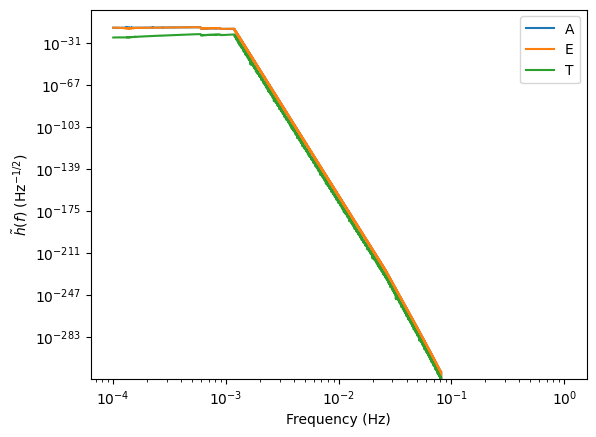

In [4]:
wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=False, fill=True, squeeze=True, length=1024)[0] 

for i, let in enumerate(["A", "E", "T"]):
    plt.loglog(freq_new, np.abs(wave[i]), label=let)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

### Adjust inspiral timing with `shift_t_limits=False`

You can move the end of the signal further back in time from merger by changing `t_obs_end`. You can also adjust how far back in time the waveform starts with `t_obs_start`. With `shift_t_limits=False`, these values are relative to `t_ref`. So `t_obs_start = 1.0` means 1 year before coalescence. 

Chopping the signal can make the signal look like it abrubtly loses power. This is the case because different harmonic modes turn off abruptly at different frequencies. 

Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

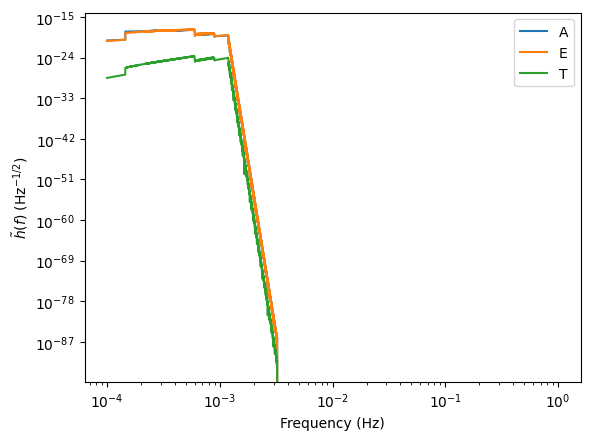

In [5]:
# start at one month
t_obs_start = 1./12.

# end 1 hour before merger
t_obs_end = 3600. / YRSID_SI

wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=False, fill=True, squeeze=True, length=1024,
                t_obs_start=t_obs_start, t_obs_end=t_obs_end)[0] 

for i, let in enumerate(["A", "E", "T"]):
    plt.loglog(freq_new, np.abs(wave[i]), label=let)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

### Adjust inspiral timing with `shift_t_limits=True`

With `shift_t_limits=True`, these values are relative to `t_ref`. So `t_obs_start = 1.0` means 1 year before coalescence. 

Based on the `t_ref` of the system we are examining, with `t_obs_start=0`, `t_obs_end=0.75` years, `shift_t_limits=True`, only an early low-power portion of the signal is observed.  

Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

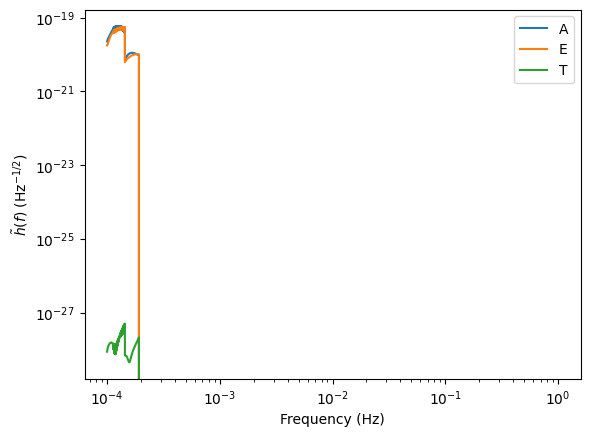

In [6]:
# start at the beginning of observation
t_obs_start = 0.0

# end after 0.75 years
t_obs_end = 0.75

wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=False, fill=True, squeeze=True, length=1024,
                shift_t_limits=True, t_obs_start=t_obs_start, t_obs_end=t_obs_end)[0] 

for i, let in enumerate(["A", "E", "T"]):
    plt.loglog(freq_new, np.abs(wave[i]), label=let)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

### Controlling interpolation

The user has the option to control the interpolation by providing the number of frequencies to interpolate over with the `length` keyword argument. 

Text(0.5, 0, 'Frequency (Hz)')

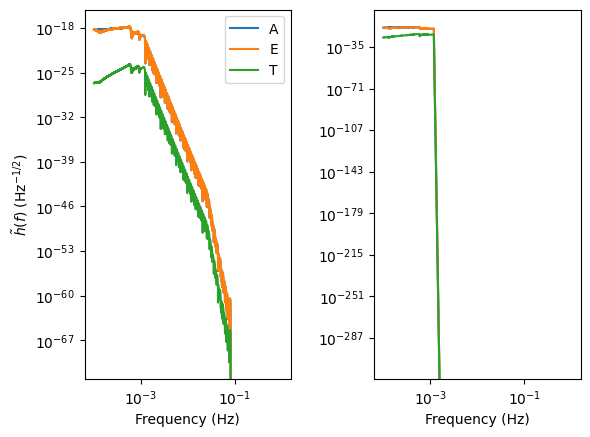

In [7]:
# number of points is too small
length = 128

wave1 = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=False, fill=True, squeeze=True, length=length,
                )[0] 

# high number of points is good
length = 16384

wave2 = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=False, fill=True, squeeze=True, length=length,
                )[0] 

fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4)
for i, let in enumerate(["A", "E", "T"]):
    ax[0].loglog(freq_new, np.abs(wave1[i]), label=let)
    ax[1].loglog(freq_new, np.abs(wave2[i]), label=let)
ax[0].legend()
ax[0].set_ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")
ax[0].set_xlabel("Frequency (Hz)")
ax[1].set_xlabel("Frequency (Hz)")

#### Check number of points that is good for interpolation:

Generally, most reasonable numbers of points are fine for interpolation. We usually put 1024 to be conservative. It can slightly affect the waveform timing.

Text(0, 0.5, 'Mismatch')

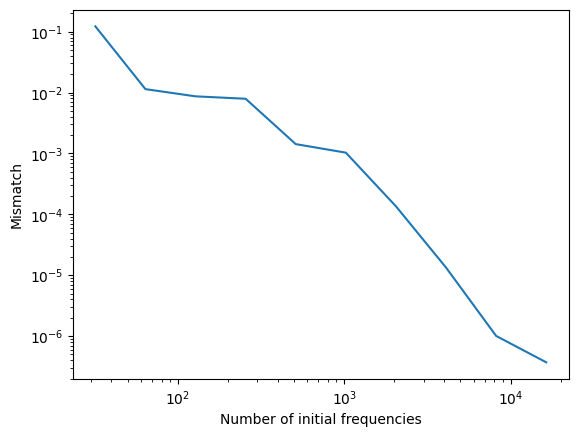

In [8]:
# compute directly first (see below)
wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=True, compress=True, squeeze=True,
                ) 

lengths_in = 2**np.arange(5, 15)[::-1]
mismatch = np.zeros_like(lengths_in, dtype=float)
for j, length in enumerate(lengths_in):
   # compute directly first (see below)
    wave_temp = wave_gen(m1, m2, a1, a2,
                              dist, phi_ref, f_ref, inc, lam, 
                              beta, psi, t_ref, freqs=freq_new,
                              direct=False, fill=True, squeeze=True, length=length
                    )[0]
    
    num = np.sum([np.dot(wave_temp[i].conj(), wave[i]) for i in range(3)])
    den1 = np.sum([np.dot(wave[i].conj(), wave[i]) for i in range(3)])
    den2 = np.sum([np.dot(wave_temp[i].conj(), wave_temp[i]) for i in range(3)])
    overlap = num / np.sqrt(den1 * den2)
    mismatch[j] = 1 - overlap.real

plt.loglog(lengths_in, mismatch) 
plt.xlabel("Number of initial frequencies")
plt.ylabel("Mismatch")

### Generate waveforms without interpolation

When interpolating, frequencies between $10^{-4}/M$ and $0.6/M$ are evaluated. Therefore, when not interpolating, the evaluation of the waveform will stretch outside these limits if frequencies outside those limits are given by the user. 

With `compress=True`, all modes will be directly combined. 

Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

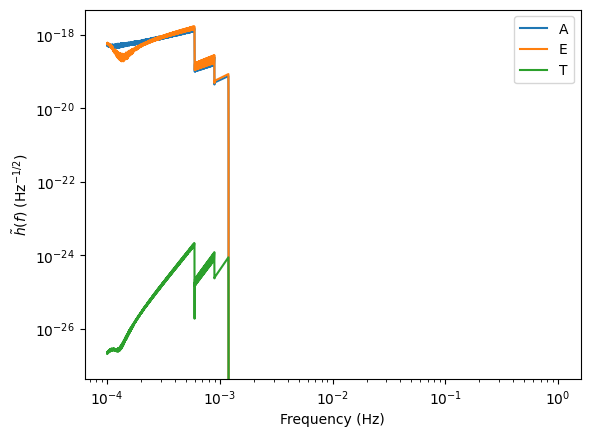

In [9]:
wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=True, compress=True, squeeze=True,
                ) 

for i, let in enumerate(["A", "E", "T"]):
    plt.loglog(freq_new, np.abs(wave[i]), label=let)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")


With `compress=False`, it will keep the modes separate.

(1e-27, 1e-14)

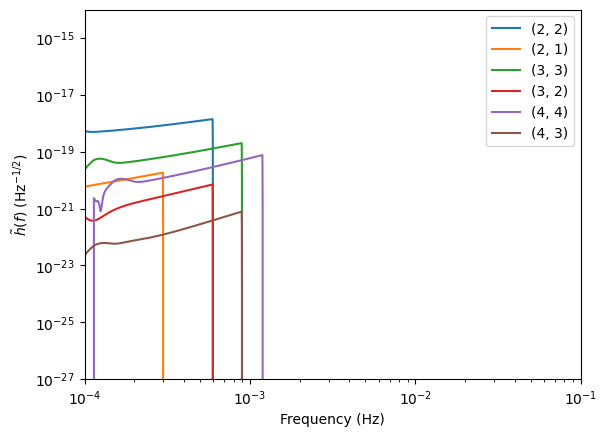

In [10]:
wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=True, compress=False, squeeze=True,
                ) 

for i, mode in enumerate(wave_gen.amp_phase_gen.modes):
    plt.loglog(freq_new, np.abs(wave[0][i]), label=mode)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

plt.xlim(1e-4, 1e-1)
plt.ylim(1e-27, 1e-14)

### Adjusting mode content

You can adjust the mode content with the `modes` keyword argument. You will receive an error if the requested mode indices $(l,m)$ are not available for the given waveform model chosen. 

(1e-27, 1e-14)

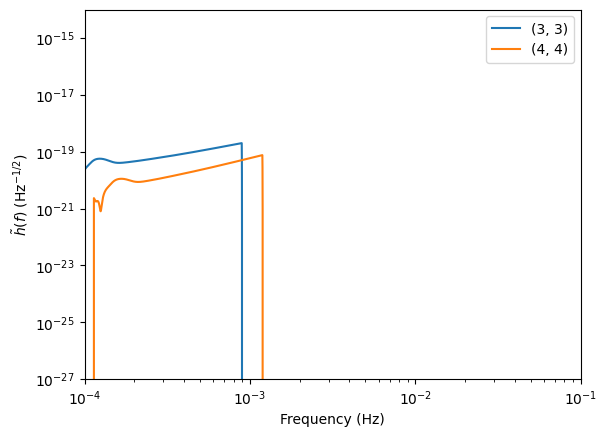

In [11]:
wave = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=[(3,3),(4,4)], direct=True, compress=False, squeeze=True,
                ) 

for i, mode in enumerate(wave_gen.amp_phase_gen.modes):
    plt.loglog(freq_new, np.abs(wave[0][i]), label=mode)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

plt.xlim(1e-4, 1e-1)
plt.ylim(1e-27, 1e-14)

### All of these functions can take arrays for parameters

Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

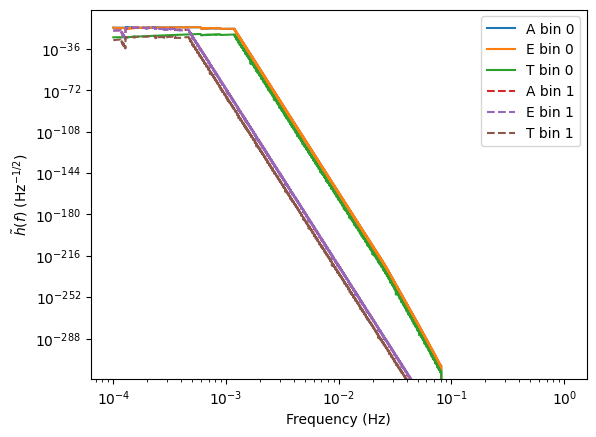

In [12]:
# set parameters
f_ref = np.array([0.0, 0.0])  # let phenom codes set fRef -> fmax = max(f^2A(f))
phi_ref = np.array([0.0, 1.0])
m1 = np.array([1e6, 4e5])
m2 = np.array([5e5, 1e5])
a1 = np.array([0.2, 0.8])
a2 = np.array([0.4, 0.7])
dist = np.array([3e3, 2.1e3])  * PC_SI * 1e6 # 3e3 in Mpc 
inc = np.array([np.pi/3, np.pi/4])
beta = np.array([np.pi/4., np.pi/5])
lam = np.array([np.pi/5., np.pi/6])
psi = np.array([np.pi/6., np.pi/7])
t_ref = np.array([1.0, 1.2]) * YRSID_SI  # in the SSB reference frame

# frequencies to interpolate to
freq_new = np.logspace(-4, 0, 10000)
modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]

waves = wave_gen(m1, m2, a1, a2,
                  dist, phi_ref, f_ref, inc, lam, 
                  beta, psi, t_ref, freqs=freq_new,
                  modes=modes, direct=False, fill=True, squeeze=False, length=1024)

for j, ls in enumerate(["solid", "dashed"]):
    for i, let in enumerate(["A", "E", "T"]):
        plt.loglog(freq_new, np.abs(waves[j][i]), label=let + f" bin {j}", ls=ls)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

### The `fill` keyword argument

The `fill` keyword argument allows the user to fill the data stream as in the first example above. However, it can give two other returns. (It is only available when `direct=False`.

If `fill=False`, it will return special information used in the fast likelihood function. This includes templates as shortened arrays (only the values where $\tilde{h}(f)$ is non-zero), the information on which frequency each array starts at and its length.

[array([[-5.17689020e-019+3.10716143e-018j,
         3.09513055e-018+2.22650263e-019j,
        -8.91078695e-020-3.29350134e-018j, ...,
        -4.58978912e-313+2.10347829e-312j,
        -1.43224624e-312-8.85778293e-314j,
        -3.51814680e-313-1.48532253e-313j],
       [ 3.45314862e-018+1.37751740e-019j,
        -1.51344982e-019-3.58801144e-018j,
        -3.63632794e-018+3.19022787e-019j, ...,
        -4.53209462e-313-2.39957146e-312j,
         1.53458988e-312-5.42388822e-313j,
         4.33149031e-313-8.73912553e-316j],
       [-6.17870919e-027+1.16246055e-026j,
         1.15484747e-026+5.54204573e-027j,
         3.91668155e-027-1.17353039e-026j, ...,
         2.48588438e-317-1.80190682e-318j,
         3.71317506e-318+1.61919047e-317j,
        -4.95404564e-319+4.39307362e-318j]]), array([[-1.46307937e-20+2.98547626e-21j,  1.03837288e-20-1.07606328e-20j,
        -2.04441355e-21+1.48353878e-20j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.

Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

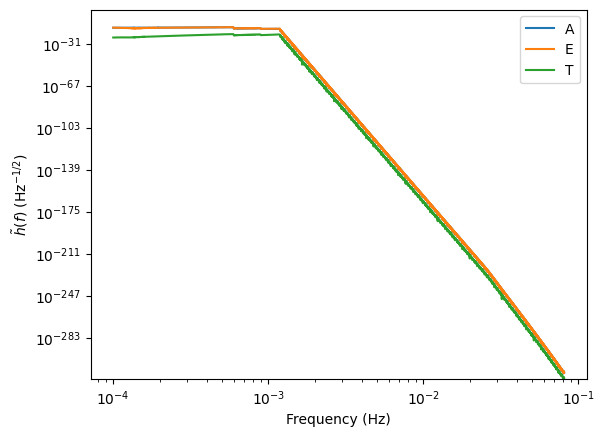

In [13]:
templates, start_inds, lengths = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=freq_new,
                          modes=modes, direct=False, fill=False, squeeze=False, length=1024)

print(templates, start_inds, lengths)

# plot the first binary
for i, let in enumerate(["A", "E", "T"]):
    plt.loglog(freq_new[start_inds[0]:start_inds[0] + lengths[0]], np.abs(templates[0][i]), label=let)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")


The binaries can also be combined into one data stream with `fill=True` and `combine=True`. 

Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

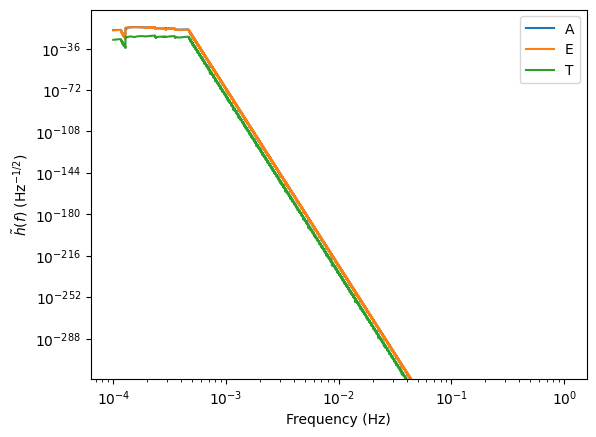

In [14]:
waves = wave_gen(m1, m2, a1, a2,
                  dist, phi_ref, f_ref, inc, lam, 
                  beta, psi, t_ref, freqs=freq_new,
                  modes=modes, direct=False, fill=True, combine=True, squeeze=False, length=1024)

for i, let in enumerate(["A", "E", "T"]):
    plt.loglog(freq_new, np.abs(waves[i]), label=let)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

## Generating PhenomHM waveforms

 Now we will create PhenomHM waveforms in the source frame, but scaled for the distance. 

In [15]:
phenomhm = PhenomHMAmpPhase(use_gpu=False, run_phenomd=False)

In [16]:
f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.0 # phase at f_ref
m1 = 1e6 
m2 = 5e5
a1 = 0.2
a2 = 0.4
dist = 18e3  * PC_SI * 1e6 # 3e3 in Mpc 
t_ref = 0.0

modes = [(2,2), (3, 3), (4, 4), (2, 1), (3, 2), (4, 3)]

phenomhm(
    m1,
    m2,
    a1,
    a2,
    dist,
    phi_ref,
    f_ref,
    t_ref,
    1024,
    modes=modes
)

# get important quantities
freqs = phenomhm.freqs_shaped  # shape (num_bin_all, length)
amps = phenomhm.amp  # shape (num_bin_all, num_modes, length)
phase = phenomhm.phase  # shape (num_bin_all, num_modes, length)
tf = phenomhm.tf  # shape (num_bin_all, num_modes, length)

Plot Amplitudes

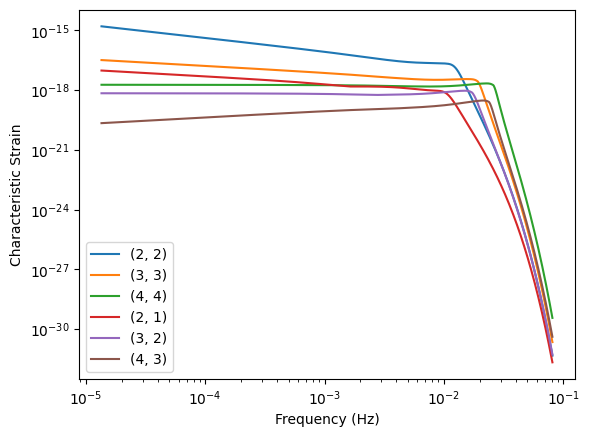

In [17]:
for i, mode in enumerate(modes):
    plt.loglog(freqs[0], np.sqrt(freqs[0]) * amps[0, i], label=mode)
    
plt.ylabel("Characteristic Strain")
plt.xlabel("Frequency (Hz)")
plt.legend()

## Fast FD Response

A large amount of the Fast FD Response codes were provided by Sylvain Marsat, so thank you to him! Detailed information on the response can be found in [arXiv:1806.10734](https://arxiv.org/abs/1806.10734) and [arXiv:2003.00357](https://arxiv.org/abs/2003.00357). The response works by applying an effective transfer function, $\mathcal{T}(f, t(f))$, to the waveform to get the TDI channels: 
$$\tilde{h}^{AET}(f) = \mathcal{T}(f, t(f))\tilde{h}^\text{SSB}(f),$$
where $t(f)$ is the time-frequency correspondence. This determines where the LISA constellation is in its orbit. This response function assumes the arms of the constellation are constant in time.

The response function operates directly on information coming from the base waveform generation in PhenomHM when you run `BBHWaveformFD`. To run the response separately you need to provide a phase and tf vector. The phase is adjusted inside the response code. If you do not want that to happen, you can add the keyword argument `adjust_phase=False`. If you are just running the response function to use it itself and not using to adjust phase, you can just put in zeros for the phase, it will not affect the computation. All parameters for the response are in the SSB frame. This function can take 1D arrays for the parameters as well. In this case, you need `freqs.shape=(num_bin_all, length)`, `phases.shape=tf.shape=(num_bin_all, num_modes, length)` with `num_bin_all` the total number of binaries, `num_modes` the number of harmonics, and `length` number of frequencies to evaluate per binary. 

Text(0, 0.5, '$\\mathcal{T}(f, t(f))$')

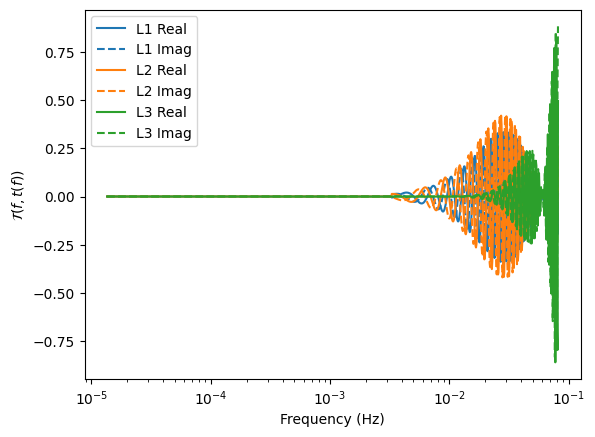

In [18]:
# use phase/tf information from last waveform run
freqs = phenomhm.freqs.copy()
phase = phenomhm.phase.copy()
tf = phenomhm.tf.copy()
modes = phenomhm.modes

phi_ref = 0.0
inc = np.pi/4
beta = np.pi/5
lam = np.pi/6
psi = np.pi/7

length = freqs.shape[-1]

response = LISATDIResponse()
response(freqs,
        inc,
        lam,
        beta,
        psi,
        phi_ref,
        length,
        phase=phase,
        tf=tf,
        modes=modes)

# plot parts of the response
for i in range(1, 4):
    
    # (2, 2) mode
    index = response.modes.index((2,2))
    # response.transferL1
    transfer = getattr(response, f"transferL{i}")
    plt.semilogx(freqs, transfer.real[0, index], label=f"L{i} Real", ls="solid", color=f"C{i-1}")
    plt.semilogx(freqs, transfer.imag[0, index], label=f"L{i} Imag", ls="dashed", color=f"C{i-1}")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathcal{T}(f, t(f))$")

(10, 1024) (10, 6, 1024) (10, 6, 1024) (10, 6, 1024)


Text(0, 0.5, 'Phase Difference from Response Function')

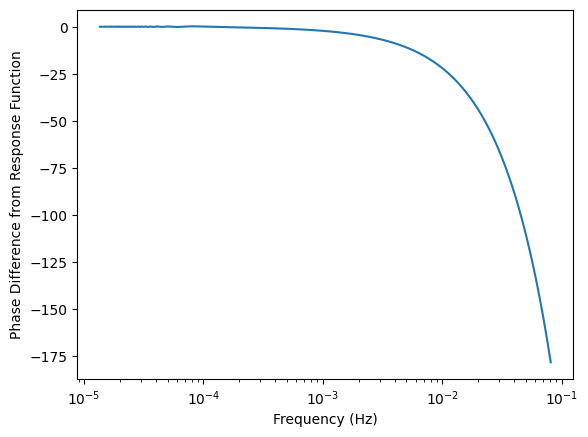

In [19]:
# use phase/tf information from last waveform run

num_bin_all = 10

freqs = np.tile(phenomhm.freqs.copy(), (num_bin_all, 1))
phase = np.tile(phenomhm.phase.copy(), (num_bin_all, 1, 1))
tf = np.tile(phenomhm.tf.copy(), (num_bin_all, 1, 1))

phi_ref = np.full(num_bin_all, 0.0)
inc = np.full(num_bin_all, np.pi/4)
beta = np.full(num_bin_all, np.pi/5)
lam = np.full(num_bin_all, np.pi/6)
psi = np.full(num_bin_all, np.pi/7)

length = freqs.shape[-1]

response(
    freqs,
    inc,
    lam,
    beta,
    psi,
    phi_ref,
    length,
    phase=phase,
    tf=tf,
    modes=None,  # defaults to phenomhm modes
    adjust_phase=True, # if you want to keep the phase array you input the same, set this to false. 
)  # You can get adjusted phases with response.phase
print(freqs.shape, phase.shape, tf.shape, response.transferL1.shape)

# get phase adjustment by response function
phase_diff = phase - phenomhm.phase

plt.semilogx(freqs[0], phase_diff[0, 0])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase Difference from Response Function")

If building a waveform, you can also put a larger buffer object directly into the response code. This larger buffer object would be carrying amplitudes, phases, and tf from the source-frame waveform generator in a flattened 1D array. 

In [20]:
num_bin_all = 10

length = 1024
num_modes = len(response.modes)
buffer_shape = (9, num_bin_all, num_modes, length)
out_buffer = np.zeros(buffer_shape).flatten()

f_ref = np.full(num_bin_all, 0.0)  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = np.full(num_bin_all, 0.0) # phase at f_ref
t_ref = np.full(num_bin_all, 0.0) # time at f_ref
m1 = np.full(num_bin_all, 1e6) 
m2 = np.full(num_bin_all, 5e5)
a1 = np.full(num_bin_all, 0.2)
a2 = np.full(num_bin_all, 0.4)
dist = np.full(num_bin_all, 3e3)  * PC_SI * 1e6 # 3e3 in Mpc 

inc = np.full(num_bin_all, np.pi/4)
beta = np.full(num_bin_all, np.pi/5)
lam = np.full(num_bin_all, np.pi/6)
psi = np.full(num_bin_all, np.pi/7)

phenomhm(
    m1,
    m2,
    a1,
    a2,
    dist,
    phi_ref,
    f_ref,
    t_ref,
    length,
    out_buffer=out_buffer
)

print(out_buffer.reshape(buffer_shape)[:, 0, 0, 0])

response(
    freqs,
    inc,
    lam,
    beta,
    psi,
    phi_ref,
    length,
    out_buffer=out_buffer,
    modes=None,  # defaults to phenomhm modes
) 

print(out_buffer.reshape(buffer_shape)[:, 0, 0, 0])
# these are all numbers at the first frequency for (2,2) mode for
# amp, phase, tf, transferL1re, transferL1im, transferL2re, transferL2im, transferL3re, transferL3im

[ 2.59987559e-12  7.38281574e+04 -1.44109019e+09  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
[ 2.59987559e-12  7.38281579e+04 -1.44109019e+09 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


## Computing the Likelihood

The gravitational-wave likelihood, $\mathcal{L}$, is given by
$$\log{\mathcal{L}}\propto -\frac{1}{2}\langle d-h|d-h\rangle = -\frac{1}{2}\left( \langle d|d\rangle + \langle h|h\rangle - 2\langle d|h\rangle \right),$$
where $\langle a|b\rangle$ is the noise-weighted inner product between time-domain strain signals $a(t)$ and $b(t)$. This inner product is given by
$$ \langle a|b\rangle = 4\text{Re}\int_0^\infty\frac{\tilde{a}(f)^*\tilde{b}(f)}{S_n(f)}df,$$
where $S_n(f)$ is the one-sided Power Spectral Density in the noise. 

### Computing the log-Likelihood for MBHBs directly against the Fourier transform of data

One option in `bbhx` for computing the likelihood is a direct Likeihood computation: `bbhx.likelihood.Likelihood`. You will need `lisatools` if you want to compute the sensitivity curves. Otherwise, put in your own sensitivity functions or np.ones to get it to work.  

In [21]:
######## generate data
# set parameters
f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.0 # phase at f_ref
m1 = 1e6 
m2 = 5e5
a1 = 0.2
a2 = 0.4
dist = 18e3  * PC_SI * 1e6 # 3e3 in Mpc 
inc = np.pi/3.
beta = np.pi/4.  # ecliptic latitude
lam = np.pi/5.  # ecliptic longitude
psi = np.pi/6.  # polarization angle 
t_ref = 1.0 * YRSID_SI  # t_ref  (in the SSB reference frame)

T_obs = 1.2 # years
dt = 10.0

n = int(T_obs * YRSID_SI / dt)
data_freqs = np.fft.rfftfreq(n, dt)[1:] # remove DC

# frequencies to interpolate to
modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
waveform_kwargs = dict(modes=modes, direct=False, fill=True, squeeze=True, length=1024)

data_channels = wave_gen(m1, m2, a1, a2,
                          dist, phi_ref, f_ref, inc, lam, 
                          beta, psi, t_ref, freqs=data_freqs,
                          **waveform_kwargs)[0]

######## get noise information (need lisatools)
PSD_A = get_sensitivity(data_freqs, sens_fn="A1TDISens")
PSD_E = get_sensitivity(data_freqs, sens_fn="E1TDISens")
PSD_T = get_sensitivity(data_freqs, sens_fn="T1TDISens")

df = data_freqs[1] - data_freqs[0]

psd = np.array([PSD_A, PSD_E, PSD_T])

# initialize Likelihood
like = Likelihood(
    wave_gen,
    data_freqs,
    data_channels,
    psd,
    use_gpu=False,
)

# get params
num_bins = 10
params_in = np.tile(np.array([m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]), (num_bins, 1))

# change masses for test
params_in[:, 0] *= (1 + 1e-4 * np.random.randn(num_bins))

# get_ll and not __call__ to work with lisatools
ll = like.get_ll(params_in.T, **waveform_kwargs)

print(ll, like.d_h)

[-0.56231853 -5.04761453 -0.43127672 -3.31971965 -5.35832732 -0.09739732
 -0.18954596 -1.36331031 -0.60341271 -2.97678974] [2985.9975537  -43.59816508j 2980.25281946-130.79576009j
 2987.35839562 +38.14301663j 2982.33350447-106.01475564j
 2979.8858162 -134.77467888j 2986.84026896 -18.14336574j
 2987.40200313 +25.23793256j 2984.84036964 -67.89881176j
 2987.29428656 +45.1395584j  2982.75720639-100.37933708j]


You can also phase marginalize. This occurs in the $\langle d|h \rangle$ term in the Likelihood. 

In [22]:
# get_ll and not __call__ to work with lisatools
ll_marg = like.get_ll(params_in.T, phase_marginalize=True, **waveform_kwargs)

print(np.array([ll, ll_marg]).T)

[[-0.56231853 -0.2440499 ]
 [-5.04761453 -2.17884767]
 [-0.43127672 -0.18777891]
 [-3.31971965 -1.43603024]
 [-5.35832732 -2.31208066]
 [-0.09739732 -0.04229248]
 [-0.18954596 -0.08294131]
 [-1.36331031 -0.59113294]
 [-0.60341271 -0.26239116]
 [-2.97678974 -1.28822454]]


You can also return the signal-to-noise ratio: $\langle d|h \rangle / \sqrt{\langle h|h \rangle}$.

In [23]:
# get_ll and not __call__ to work with lisatools
out = like.get_ll(params_in.T, return_extracted_snr=True, **waveform_kwargs)

# first column is log-Likelihood, second is snr
print(out)

[[-0.56231853 54.64508567]
 [-5.04761453 54.56297366]
 [-0.43127672 54.64748678]
 [-3.31971965 54.59461168]
 [-5.35832732 54.55728389]
 [-0.09739732 54.6535931 ]
 [-0.18954596 54.65190792]
 [-1.36331031 54.630426  ]
 [-0.60341271 54.64433873]
 [-2.97678974 54.60089008]]


### Heterodyned Likelihoods

Heterodyned Likelihoods are also available. See [arXiv:2109.02728](https://arxiv.org/abs/2109.02728) for details on Heterodyning in general. We specifically implement the method used in [arXiv:1806.08792](https://arxiv.org/abs/1806.08792). The practical reason for using a Heterodyned Likelihood method is the computation can be performed along a sparse array of frequencies, rather than a dense array comming from a Fourier transform. 

It is reasonably accurate with higher modes and produces the same posteriors as the full Likelihood. It uses a direct sum of modes prior to residual computation. It gets more accurate as modes are removed. 

In [24]:
reference_index = ll.argmax()

reference_params = params_in[reference_index]

# how many frequencies to use
length_f_het = 128

# initialize Likelihood
like_het = HeterodynedLikelihood(
    wave_gen,
    data_freqs,
    data_channels,
    reference_params,
    length_f_het,
    use_gpu=False,
)


# get_ll and not __call__ to work with lisatools
ll_het = like_het.get_ll(params_in.T, **waveform_kwargs)

print(np.array([ll, ll_het]).T)

[[ -0.56231853  -7.54937845]
 [ -5.04761453 -11.93909684]
 [ -0.43127672  -7.43406949]
 [ -3.31971965 -10.24724956]
 [ -5.35832732 -12.2433316 ]
 [ -0.09739732  -7.09670385]
 [ -0.18954596  -7.19381899]
 [ -1.36331031  -8.33231868]
 [ -0.60341271  -7.60479998]
 [ -2.97678974  -9.91150227]]


## Utility functions

There are some utility functions in `bbhx` than can be very useful.

### Transformation functions

When sampling on MBHBs, it can be useful to sample in the LISA constellation reference frame where the posterior modes in the sky have a generally predictable structure. In the LISA constellation referenence frame, the sky localization for a source generally has 8 sky modes: 4 longitudinal and 2 latitudinal. Longitudinal modes involve $\lambda + (0, 1, 2, 3)\times\pi/2$ and $\psi + (0, 1, 2, 3)\times\pi/2$, where $\lambda$ is the ecliptic longitude and $\psi$ is the polarization angle. The latitudinal modes are at $(\pm\beta, \pm\cos{\iota}, \pm\cos{\psi})$ where $\beta$ and $\iota$ are the ecliptic latitude and inclination, respectively.

#### Transformations to and from LISA and SSB reference frames

First, we will examine transformations of coordinates to and from the LISA and SSB reference frames. All of these functions can take arrays as input as well.

In [25]:
# start in the LISA frame
tL = YRSID_SI  # time
lambdaL = 0.5
betaL = 0.8
psiL = 0.3

tSSB, lambdaSSB, betaSSB, psiSSB = LISA_to_SSB(tL, lambdaL, betaL, psiL)
print(tSSB, lambdaSSB, betaSSB, psiSSB)

31557992.305078838 2.3277015675208466 1.0933520437673625 2.3134690745168953


From SSB to LISA:

In [26]:
tL, lambdaL, betaL, psiL = SSB_to_LISA(tSSB, lambdaSSB, betaSSB, psiSSB)
print(tL, lambdaL, betaL, psiL)

31558149.7635457 0.4999999999999887 0.8000000000000038 0.29999999999999005


#### Posterior sky-mode transformation

You can transform your sky mode parameters to all longitudinal modes. If `inplace==False`, the first dimension will be 4 times as long as the input array. 

In [27]:
inc = 0.4
lam = 3.42
beta = 0.6
psi = 1.0

coords = np.array([inc, lam, beta, psi])

# if we had the whole mbh parameter array like used in BBHWaveformFD,
# it would be dict(inc=7, lam=8, beta=9, psi=10) included f_ref as a parameter  
ind_map = dict(inc=0, lam=1, beta=2, psi=3)  

print(f"start params: {coords}")

out_coords = mbh_sky_mode_transform(coords, ind_map=ind_map, inplace=False, kind="long", cos_i=False)
print(f"end params: {out_coords}")

start params: [0.4  3.42 0.6  1.  ]
end params: [[0.4        3.42       0.6        1.        ]
 [0.4        4.99079633 0.6        2.57079633]
 [0.4        0.27840735 0.6        1.        ]
 [0.4        1.84920367 0.6        2.57079633]]


Or latitudinal transforms. If `inplace==False`, the first dimension will be 2 times as long as the input array. 

In [28]:
print(f"start params: {coords}")

out_coords = mbh_sky_mode_transform(coords, ind_map=ind_map, inplace=False, kind="lat", cos_i=False)
print(f"end params: {out_coords}")

start params: [0.4  3.42 0.6  1.  ]
end params: [[ 0.4         3.42        0.6         1.        ]
 [ 2.74159265  3.42       -0.6         2.14159265]]


Or both transforms. If `inplace==False`, the first dimension will be 8 times as long as the input array. 

In [29]:
print(f"start params: {coords}")

out_coords = mbh_sky_mode_transform(coords, ind_map=ind_map, inplace=False, kind="both", cos_i=False)
print(f"end params: {out_coords}")

start params: [0.4  3.42 0.6  1.  ]
end params: [[ 0.4         3.42        0.6         1.        ]
 [ 2.74159265  3.42       -0.6         2.14159265]
 [ 0.4         4.99079633  0.6         2.57079633]
 [ 2.74159265  4.99079633 -0.6         0.57079633]
 [ 0.4         0.27840735  0.6         1.        ]
 [ 2.74159265  0.27840735 -0.6         2.14159265]
 [ 0.4         1.84920367  0.6         2.57079633]
 [ 2.74159265  1.84920367 -0.6         0.57079633]]


You can also do these transformations in-place. When you do this, the input binaries will be assigned to new sky modes based on the transformation. Every 2, 4, or 8 binaries will be given the same sky mode transformation if latitudinal, longitudinal, or both transformations are applied, respectively. 

In [30]:
in_coords = np.tile(np.array([inc, lam, beta, psi]), (16, 1))
print(f"start params: {in_coords}")

out_coords = mbh_sky_mode_transform(in_coords, ind_map=ind_map, inplace=True, kind="both", cos_i=False)
print(f"end params: {out_coords}")

start params: [[0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]
 [0.4  3.42 0.6  1.  ]]
end params: [[ 0.4         3.42        0.6         1.        ]
 [ 2.74159265  3.42       -0.6         2.14159265]
 [ 0.4         4.99079633  0.6         2.57079633]
 [ 2.74159265  4.99079633 -0.6         0.57079633]
 [ 0.4         0.27840735  0.6         1.        ]
 [ 2.74159265  0.27840735 -0.6         2.14159265]
 [ 0.4         1.84920367  0.6         2.57079633]
 [ 2.74159265  1.84920367 -0.6         0.57079633]
 [ 0.4         3.42        0.6         1.        ]
 [ 2.74159265  3.42       -0.6         2.14159265]
 [ 0.4         4.99079633  0.6         2.57079633]
 [ 2.74159265  4.99079633 -0.6         0.570

## Citations

You can access citations for each class with the `citation` property. 

In [31]:
print(wave_gen.citation)


@article{Katz:2020hku,
    author = "Katz, Michael L. and Marsat, Sylvain and Chua, Alvin J. K. and Babak, Stanislav and Larson, Shane L.",
    title = "{GPU-accelerated massive black hole binary parameter estimation with LISA}",
    eprint = "2005.01827",
    archivePrefix = "arXiv",
    primaryClass = "gr-qc",
    doi = "10.1103/PhysRevD.102.023033",
    journal = "Phys. Rev. D",
    volume = "102",
    number = "2",
    pages = "023033",
    year = "2020"
}

@article{Katz:2021uax,
    author = "Katz, Michael L.",
    title = "{A fully-automated end-to-end pipeline for massive black hole binary signal extraction from LISA data}",
    eprint = "2111.01064",
    archivePrefix = "arXiv",
    primaryClass = "gr-qc",
    month = "11",
    year = "2021"
}

@article{michael katz_2021,
    title={mikekatz04/BBHx: First official public release},
    DOI={10.5281/zenodo.5730688},
    abstractNote={No description provided.},
    publisher={Zenodo},
    author={Michael Katz},
    year={2021},
 